In [2]:
import gc
gc.collect()
import numpy as np
import pandas as pd
import os
import h5py
import time
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

# TPU initialization moved to top for better efficiency
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import R2Score as RSquare
from sklearn.preprocessing import StandardScaler

# Fixed TPU strategy setup for Kaggle TPUv5
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     tpu_strategy = tf.distribute.TPUStrategy(tpu)
#     print(f"Running on TPU with {tpu_strategy.num_replicas_in_sync} cores")
# except (ValueError, RuntimeError):
tpu_strategy = tf.distribute.get_strategy()
print("Running on CPU/GPU")

all_files=[]
for dirname, _, filenames in os.walk('./data_set'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))
all_files.sort()
pprint(all_files)

Running on CPU/GPU
['./data_set/N-CMAPSS_DS01-005.h5',
 './data_set/N-CMAPSS_DS02-006.h5',
 './data_set/N-CMAPSS_DS03-012.h5',
 './data_set/N-CMAPSS_DS04.h5',
 './data_set/N-CMAPSS_DS05.h5',
 './data_set/N-CMAPSS_DS06.h5',
 './data_set/N-CMAPSS_DS07.h5',
 './data_set/N-CMAPSS_DS08a-009.h5',
 './data_set/N-CMAPSS_DS08c-008.h5',
 './data_set/N-CMAPSS_DS08d-010.h5',
 './data_set/N-CMAPSS_Example_data_loading_and_exploration.ipynb',
 './data_set/Run_to_Failure_Simulation_Under_Real_Flight_Conditions_Dataset.pdf',
 './data_set/data-06-00005-v2.pdf',
 './data_set/flight_profile_DS02.png',
 './data_set/kde_DS02.png']


In [4]:
def read_hdf(filename):
    t = time.process_time()  
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'), dtype=np.float32)
        X_s_dev = np.array(hdf.get('X_s_dev'), dtype=np.float32)
        X_v_dev = np.array(hdf.get('X_v_dev'), dtype=np.float32)
        T_dev = np.array(hdf.get('T_dev'), dtype=np.float32)
        Y_dev = np.array(hdf.get('Y_dev'), dtype=np.float32)
        A_dev = np.array(hdf.get('A_dev'), dtype=np.float32)

        # Test set
        W_test = np.array(hdf.get('W_test'), dtype=np.float32)
        X_s_test = np.array(hdf.get('X_s_test'), dtype=np.float32)
        X_v_test = np.array(hdf.get('X_v_test'), dtype=np.float32)
        T_test = np.array(hdf.get('T_test'), dtype=np.float32)
        Y_test = np.array(hdf.get('Y_test'), dtype=np.float32)
        A_test = np.array(hdf.get('A_test'), dtype=np.float32)
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                        
    ## Train data
    df_a_dev=pd.DataFrame(A_dev,columns=A_var)
    df_t_dev=pd.DataFrame(T_dev,columns=T_var)
    df_w_dev=pd.DataFrame(W_dev,columns=W_var)
    df_xs_dev=pd.DataFrame(X_s_dev,columns=X_s_var)
    df_xv_dev=pd.DataFrame(X_v_dev,columns=X_v_var)
    df_y_dev=pd.DataFrame(Y_dev,columns=['RUL'])

    #get rul
    trainy=df_y_dev[['RUL']]

    #get x from sensors values
    trainx=pd.concat([df_xs_dev,df_w_dev],axis=1)

    print(type(trainy),trainy.shape, type(trainx), trainx.shape)

    ## Test data
    df_a_test=pd.DataFrame(A_test,columns=A_var)
    df_t_test=pd.DataFrame(T_test,columns=T_var)
    df_w_test=pd.DataFrame(W_test,columns=W_var)
    df_xs_test=pd.DataFrame(X_s_test,columns=X_s_var)
    df_xv_test=pd.DataFrame(X_v_test,columns=X_v_var)
    df_y_test=pd.DataFrame(Y_test,columns=['RUL'])

    #get health state from aux
    testy=df_y_test[['RUL']]

    #get x from sensors values
    testx=pd.concat([df_xs_test,df_w_test],axis=1)

    print(type(testy),testy.shape, type(testx), testx.shape)

    print('')
    print("Operation time (min): " , (time.process_time()-t)/60)
    print('')

    return (trainx,trainy,df_a_dev,testx,testy,df_a_test)

In [5]:
curr_file=all_files[2]
print(curr_file)

./data_set/N-CMAPSS_DS03-012.h5


In [6]:
trainx,trainy,adev,testx,testy,atest = read_hdf(filename=curr_file)

<class 'pandas.core.frame.DataFrame'> (5571277, 1) <class 'pandas.core.frame.DataFrame'> (5571277, 18)
<class 'pandas.core.frame.DataFrame'> (4251560, 1) <class 'pandas.core.frame.DataFrame'> (4251560, 18)

Operation time (min):  0.30133962499999994



In [7]:
trainx.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571277 entries, 0 to 5571276
Data columns (total 18 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   T24     5571277 non-null  float32
 1   T30     5571277 non-null  float32
 2   T48     5571277 non-null  float32
 3   T50     5571277 non-null  float32
 4   P15     5571277 non-null  float32
 5   P2      5571277 non-null  float32
 6   P21     5571277 non-null  float32
 7   P24     5571277 non-null  float32
 8   Ps30    5571277 non-null  float32
 9   P40     5571277 non-null  float32
 10  P50     5571277 non-null  float32
 11  Nf      5571277 non-null  float32
 12  Nc      5571277 non-null  float32
 13  Wf      5571277 non-null  float32
 14  alt     5571277 non-null  float32
 15  Mach    5571277 non-null  float32
 16  TRA     5571277 non-null  float32
 17  T2      5571277 non-null  float32
dtypes: float32(18)
memory usage: 382.5 MB


In [8]:
# Standard scale with memory optimization
sc=StandardScaler()
sc.fit(trainx.values)
trainx_l_sc=sc.transform(trainx.values).astype(np.float32)
testx_l_sc=sc.transform(testx.values).astype(np.float32)

print(trainx_l_sc.shape, testx_l_sc.shape, trainy.shape, testy.shape)

trainx_l_sc=pd.DataFrame(trainx_l_sc,columns=trainx.columns)
testx_l_sc=pd.DataFrame(testx_l_sc,columns=trainx.columns)

print(trainx_l_sc.shape, testx_l_sc.shape, trainy.shape, testy.shape)

(5571277, 18) (4251560, 18) (5571277, 1) (4251560, 1)
(5571277, 18) (4251560, 18) (5571277, 1) (4251560, 1)


In [9]:
def time_window_slicing_sample(input_array, window_length, unit, sequence_cols, stride=1):
    window_lst = []
    input_temp = input_array[input_array['unit'] == unit][sequence_cols].values.astype(np.float32)
    print ("Unit%s input array shape: " %unit, input_temp.shape)
    num_samples = int((input_temp.shape[0] - window_length)/stride) + 1

    for i in range(num_samples):
        window = input_temp[i*stride:i*stride + window_length,:]
        window_lst.append(window)

    sample_array = np.dstack(window_lst).astype(np.float32)
    print ("sample_array.shape", sample_array.shape)
    return sample_array

def time_window_slicing_label(input_array, window_length, unit, sequence_cols = 'RUL', stride=1):
    window_lst = []
    input_temp = input_array[input_array['unit'] == unit][sequence_cols].values.astype(np.float32)
    num_samples = int((input_temp.shape[0] - window_length)/stride) + 1
    for i in range(num_samples):
        window = input_temp[i*stride:i*stride + window_length]
        window_lst.append(window)

    label_array = np.asarray(window_lst).astype(np.float32)
    return label_array[:,-1]

In [10]:
trainy = trainy[trainy!=0].dropna()
trainx_l_sc = trainx_l_sc.loc[trainy.index]
testy = testy[testy!=0].dropna()
testx_l_sc = testx_l_sc.loc[testy.index]

print(trainx_l_sc.shape, trainy.shape, testy.shape, testx_l_sc.shape)

(5486397, 18) (5486397, 1) (4189932, 1) (4189932, 18)


In [11]:
df=trainx_l_sc.copy()
df['unit']=adev['unit']
df['RUL']=trainy['RUL']

In [12]:
# Optimized windowing with reduced window size for memory efficiency
WINDOW_SIZE = 30  # Reduced from 50
STRIDE = 15      # Reduced from 25

all_units_data=[]
for un in adev.unit.unique():
    all_units_data.append(time_window_slicing_sample(df, WINDOW_SIZE, un, df.columns.difference(['unit','RUL']), STRIDE))

all_units_data=np.dstack(all_units_data)
all_units_data=all_units_data.transpose(2,0,1)
print(all_units_data.shape)

Unit1.0 input array shape:  (303829, 18)
sample_array.shape (30, 18, 20254)
Unit2.0 input array shape:  (637806, 18)
sample_array.shape (30, 18, 42519)
Unit3.0 input array shape:  (582325, 18)
sample_array.shape (30, 18, 38820)
Unit4.0 input array shape:  (530938, 18)
sample_array.shape (30, 18, 35394)
Unit5.0 input array shape:  (396645, 18)
sample_array.shape (30, 18, 26442)
Unit6.0 input array shape:  (926215, 18)
sample_array.shape (30, 18, 61746)
Unit7.0 input array shape:  (690621, 18)
sample_array.shape (30, 18, 46040)
Unit8.0 input array shape:  (1059191, 18)
sample_array.shape (30, 18, 70611)
Unit9.0 input array shape:  (358827, 18)
sample_array.shape (30, 18, 23920)
(365746, 30, 18)


In [13]:
all_labels=[]
for un in adev.unit.unique():
    all_labels=all_labels+time_window_slicing_label(df, WINDOW_SIZE, un, stride=STRIDE).tolist()

print(len(all_labels))
all_labels=np.array(all_labels, dtype=np.float32)

365746


In [14]:
#test data
df=testx_l_sc.copy()
df['unit']=atest['unit']
df['RUL']=testy['RUL']

test_units_data=[]
for un in atest.unit.unique():
    test_units_data.append(time_window_slicing_sample(df, WINDOW_SIZE, un, df.columns.difference(['unit','RUL']), STRIDE))

test_units_data=np.dstack(test_units_data)
test_units_data=test_units_data.transpose(2,0,1)
print(test_units_data.shape)

test_labels=[]
for un in atest.unit.unique():
    test_labels=test_labels+time_window_slicing_label(df, WINDOW_SIZE, un, stride=STRIDE).tolist()

print(len(test_labels))
test_labels=np.array(test_labels, dtype=np.float32)

Unit10.0 input array shape:  (938592, 18)
sample_array.shape (30, 18, 62571)
Unit11.0 input array shape:  (814152, 18)
sample_array.shape (30, 18, 54275)
Unit12.0 input array shape:  (399732, 18)
sample_array.shape (30, 18, 26647)
Unit13.0 input array shape:  (1089493, 18)
sample_array.shape (30, 18, 72631)
Unit14.0 input array shape:  (340824, 18)
sample_array.shape (30, 18, 22720)
Unit15.0 input array shape:  (607139, 18)
sample_array.shape (30, 18, 40474)
(279318, 30, 18)
279318


In [15]:
from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval=train_test_split(all_units_data,all_labels,test_size=0.2, random_state=42)

ytrain = ytrain.reshape([-1, 1])
yval = yval.reshape([-1, 1])
test_labels = test_labels.reshape([-1, 1])

print(f"Final shapes - Train: {xtrain.shape}, Val: {xval.shape}, Test: {test_units_data.shape}")

# Clean up memory
del all_units_data, all_labels, adev, trainx, trainy, trainx_l_sc
gc.collect()

Final shapes - Train: (292596, 30, 18), Val: (73150, 30, 18), Test: (279318, 30, 18)


1797

In [16]:
# Optimized batch size for TPUv5 and memory constraints
# Use smaller batch size to avoid memory issues

# BATCH_SIZE = 32
BATCH_SIZE = 2048

BUFFER_SIZE = 5000  # Further reduced buffer size

# Ensure data types
xtrain = xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
xval = xval.astype(np.float32)
yval = yval.astype(np.float32)
test_units_data = test_units_data.astype(np.float32)
test_labels = test_labels.astype(np.float32)

# Optimized tf.data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_ds = tf.data.Dataset.from_tensor_slices((xval, yval))
test_ds = tf.data.Dataset.from_tensor_slices((test_units_data, test_labels))

AUTOTUNE = tf.data.AUTOTUNE

# More efficient data pipeline with explicit options
train_gen = (
    train_ds
    .shuffle(buffer_size=BUFFER_SIZE, seed=42, reshuffle_each_iteration=False)
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(2)  # Fixed prefetch value instead of AUTOTUNE
)

val_gen = (
    val_ds
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(2)  # Fixed prefetch value
)

test_gen = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(2)  # Fixed prefetch value
)

print("✅ Optimized tf.data pipelines created successfully.")

✅ Optimized tf.data pipelines created successfully.


In [17]:
# Enhanced transformer encoder for sequential data
class Shape(tf.keras.layers.Layer):
    def call(self,x):
        return tf.shape(x)

def transformer_encoder_v4(inputs, head_size, num_heads, ff_dim, dropout, use_causal_mask=False):
    """Sequential-data optimized transformer block with causal attention option."""
    
    # Pre-LayerNorm for better gradient flow
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # Multi-head attention with causal masking for sequential data
    attention_layer = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, 
        num_heads=num_heads, 
        dropout=dropout,
        use_bias=False
    )
    
    attention_output = attention_layer(x, x, use_causal_mask=use_causal_mask)    
    attention_output = tf.keras.layers.Dropout(dropout)(attention_output)
    res1 = attention_output + inputs

    # Enhanced feed-forward with residual connections
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res1)
    
    # Two-layer feed-forward with residual connection
    x_ff = tf.keras.layers.Dense(ff_dim, activation="gelu", use_bias=False)(x)
    x_ff = tf.keras.layers.Dropout(dropout)(x_ff)
    x_ff = tf.keras.layers.Dense(inputs.shape[-1], use_bias=False)(x_ff)
    
    return x_ff + res1

# Positional encoding for sequential data
def positional_encoding_layer(sequence_length, d_model, max_wavelength=10000):
    """Sinusoidal positional encoding for sequential data."""
    position = tf.cast(tf.range(sequence_length)[:, tf.newaxis], dtype=tf.float32)
    div_term = tf.exp(tf.cast(tf.range(0, d_model, 2), dtype=tf.float32) * 
                      -(tf.math.log(float(max_wavelength)) / d_model))
    
    pos_encoding = tf.zeros((sequence_length, d_model))
    pos_encoding = tf.concat([
        tf.sin(position * div_term),
        tf.cos(position * div_term)
    ], axis=-1)
    
    if d_model % 2 == 1:
        pos_encoding = pos_encoding[:, :-1]
    
    return pos_encoding

class PositionalEncoding(tf.keras.layers.Layer):
    """Learnable positional encoding layer for sequential data."""
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.d_model = d_model
        
    def build(self, input_shape):
        self.pos_encoding = self.add_weight(
            name='pos_encoding',
            shape=(self.sequence_length, self.d_model),
            initializer='uniform',
            trainable=True
        )
        super(PositionalEncoding, self).build(input_shape)
    
    def call(self, inputs):
        return inputs + self.pos_encoding

# Temporal convolutional layer for local sequential patterns
def temporal_conv_block(inputs, filters, kernel_size, dropout):
    """1D convolutional block to capture local temporal patterns."""
    x = tf.keras.layers.Conv1D(
        filters=filters, 
        kernel_size=kernel_size, 
        padding='same', 
        activation='gelu',
        use_bias=False
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    # Residual connection if dimensions match
    if inputs.shape[-1] == filters:
        x = x + inputs
    
    return x

In [18]:
import keras_tuner
import keras_nlp
class ReduceSumLayer(tf.keras.layers.Layer):
    def call(self,x):
        return tf.reduce_sum(x,axis=1)
def build_sequential_transformer(hp):
    """Enhanced transformer model specifically designed for sequential RUL prediction."""
    # Reduced input shape due to smaller window
    input_shape = (WINDOW_SIZE, 18)
    
    # Hyperparameters optimized for sequential data
    head_size = hp.Choice("head_size", [8, 16, 32])
    num_heads = hp.Choice("num_heads", [2, 4, 6])  # Even numbers work better
    ff_dim = hp.Choice("ff_dim", [64, 128, 256])
    num_transformer_blocks = hp.Int("num_blocks", min_value=2, max_value=6, step=1)
    mlp_units = hp.Int("mlp_units", min_value=1, max_value=3, step=1)
    learning_rate = hp.Choice("learning_rate", [1e-3, 5e-4, 1e-4, 5e-5])
    
    # Sequential data specific parameters
    # use_causal_mask = True  # For degradation prediction
    use_causal_mask = hp.Boolean("use_causal_mask")  # For degradation prediction
    use_temp_conv = hp.Boolean("use_temp_conv")      # Local temporal patterns
    pos_encoding_type = hp.Choice("pos_encoding", ["learnable", "sinusoidal", "none"])
    
    with tpu_strategy.scope():
        inputs = tf.keras.Input(shape=input_shape)
        x = inputs
        
        # Temporal convolutional preprocessing for local patterns
        if use_temp_conv:
            temp_filters = hp.Choice("temp_filters", [16, 32])
            temp_kernel = hp.Choice("temp_kernel", [3, 5])
            temp_dropout = hp.Float('temp_dropout', min_value=0.1, max_value=0.3, step=0.1)
            x = temporal_conv_block(x, temp_filters, temp_kernel, temp_dropout)
            x = temporal_conv_block(x, input_shape[-1], 1, temp_dropout)  # Project back
        
        # Positional encoding for sequential awareness
        if pos_encoding_type == "learnable":
            x = PositionalEncoding(input_shape[0], input_shape[1])(x)
        elif pos_encoding_type == "sinusoidal":
            pos_enc = positional_encoding_layer(input_shape[0], input_shape[1])
            x = x + pos_enc
        
        # Transformer blocks for long-range dependencies
        for i in range(num_transformer_blocks):
            dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.4, step=0.1)
            x = transformer_encoder_v4(x, head_size, num_heads, ff_dim, dropout_rate, use_causal_mask)
        
        # Sequence aggregation strategies
        aggregation = hp.Choice("aggregation", ["attention","last", "mean", "max"])
        
        if aggregation == "last":
            # Last timestep - most relevant for RUL
            x = x[:, -1, :]
        elif aggregation == "mean":
            x = tf.keras.layers.GlobalAveragePooling1D()(x)
        elif aggregation == "max":
            x = tf.keras.layers.GlobalMaxPooling1D()(x)
        elif aggregation == "attention":
            # Learnable attention weighting
            attention_weights = tf.keras.layers.Dense(1, activation='softmax')(x)
            # x = tf.reduce_sum(x * attention_weights, axis=1)
            x = ReduceSumLayer()(x*attention_weights)
        
        # Enhanced MLP head with skip connections
        original_dim = x.shape[-1]
        for i in range(mlp_units):
            dim = hp.Choice(f'dim_{i}', [32, 64, 128, 256])
            mlp_dropout = hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
            mlp_activation = hp.Choice(f'mlp_activ_{i}', ['gelu', 'swish', 'relu'])
            
            x_dense = tf.keras.layers.Dense(dim, activation=mlp_activation, use_bias=False)(x)
            x_dense = tf.keras.layers.BatchNormalization()(x_dense)
            x_dense = tf.keras.layers.Dropout(mlp_dropout)(x_dense)
            
            # Skip connection if dimensions allow
            if i == 0 and original_dim == dim:
                x = x_dense + x
            else:
                x = x_dense
        
        # Final regression layer with optional activation
        final_activation = hp.Choice("final_activation", ["linear", "relu"])
        outputs = tf.keras.layers.Dense(1, activation=final_activation)(x)
        
        model = tf.keras.Model(inputs, outputs)

        # Enhanced optimizer selection with schedule
        optimizer_type = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop'])
        # use_schedule = hp.Boolean('use_lr_schedule')

        
        if optimizer_type == 'adamw':
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=learning_rate, 
                weight_decay=1e-4,
                clipnorm=1.0
            )
        elif optimizer_type == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(
                learning_rate=learning_rate,
                clipnorm=1.0
            )
        else:
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=1.0
            )
        
        # Enhanced loss function for RUL prediction
        loss_type = hp.Choice('loss', ['mse', 'mae', 'huber'])
        if loss_type == 'huber':
            loss = tf.keras.losses.Huber(delta=1.0)  # Robust to outliers
        elif loss_type == 'mae':
            loss = tf.keras.losses.MeanAbsoluteError()
        else:
            loss = tf.keras.losses.MeanSquaredError()
            
        model.compile(
            loss=loss,
            optimizer=optimizer, 
            metrics=["mean_absolute_error", "mean_squared_error"]
        )
    
    return model

/home/uttam/miniconda3/envs/tfgpu3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# Test the sequential model creation
# with tpu_strategy.scope():
#     test_model = build_sequential_transformer(keras_tuner.HyperParameters())
#     test_model.summary()
#     print(f"Model has {test_model.count_params():,} parameters")

In [21]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_sequential_transformer,
    objective="val_mean_absolute_error",
    max_trials=100,  
    executions_per_trial=2,
    overwrite=False,#set True when training new
    directory="keras_tuner_sequential",
    project_name="sequential_transformer_rul",
    distribution_strategy=tpu_strategy,
    max_consecutive_failed_trials=5
)

# tuner.search_space_summary()

Reloading Tuner from keras_tuner_sequential/sequential_transformer_rul/tuner0.json


In [ ]:
# Enhanced callbacks for sequential training
import os
os.makedirs('checkpoints', exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=12, 
        restore_best_weights=True, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.7, 
        patience=5, 
        min_lr=1e-8, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'checkpoints/best_sequential_model.weights.h5', 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss'
    )
]
# callbacks.append(lr_sche)

In [1]:
import tensorflow as tf
tf.__version__


2025-10-04 16:38:15.250046: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-04 16:38:15.324525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759595895.341278  477833 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759595895.347358  477833 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-04 16:38:15.444114: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

'2.18.1'

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Sequential model training with fallback
try:
    print("Starting sequential transformer hyperparameter search...")
    history = tuner.search(
        train_gen,
        verbose=2,
        epochs=100,
        validation_data=val_gen, 
        callbacks=callbacks[:2]  # Skip checkpoint for tuning
    )
    
    # Get best model
    with tpu_strategy.scope():
        best_hps = tuner.get_best_hyperparameters()[0]
        print("Optimal hyperparameters for sequential model:")
        for hp_name in best_hps.values.keys():
            print(f"{hp_name}: {best_hps.get(hp_name)}")
        
        model = build_sequential_transformer(best_hps)
    
except Exception as e:
    print(f"Sequential tuner failed with error: {e}")
   

Trial 79 Complete [00h 03m 15s]

Best val_mean_absolute_error So Far: 4.865237236022949
Total elapsed time: 1d 04h 50m 13s

Search: Running Trial #80

Value             |Best Value So Far |Hyperparameter
32                |32                |head_size
4                 |6                 |num_heads
128               |64                |ff_dim
4                 |3                 |num_blocks
2                 |3                 |mlp_units
0.0001            |0.001             |learning_rate
True              |False             |use_causal_mask
False             |True              |use_temp_conv
sinusoidal        |sinusoidal        |pos_encoding
0.1               |0.4               |dropout_0
0.3               |0.2               |dropout_1
mean              |mean              |aggregation
64                |128               |dim_0
0.5               |0.1               |mlp_dropout_0
relu              |swish             |mlp_activ_0
relu              |linear            |final_activation
ad

2025-10-04 13:26:30.754399: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 252 bytes spill stores, 236 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_select_fusion_1', 292 bytes spill stores, 272 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_select_fusion_2', 260 bytes spill stores, 240 bytes spill loads



142/142 - 19s - 131ms/step - loss: 1659.7507 - mean_absolute_error: 34.8964 - mean_squared_error: 1659.7507 - val_loss: 1630.8353 - val_mean_absolute_error: 34.6997 - val_mean_squared_error: 1630.8353 - learning_rate: 9.5596e-05
Epoch 2/100
142/142 - 7s - 48ms/step - loss: 1549.4780 - mean_absolute_error: 33.8194 - mean_squared_error: 1549.4780 - val_loss: 1348.2363 - val_mean_absolute_error: 31.6878 - val_mean_squared_error: 1348.2363 - learning_rate: 8.3246e-05
Epoch 3/100
142/142 - 7s - 47ms/step - loss: 1468.3434 - mean_absolute_error: 33.1068 - mean_squared_error: 1468.3434 - val_loss: 1296.7137 - val_mean_absolute_error: 31.2623 - val_mean_squared_error: 1296.7137 - learning_rate: 6.5368e-05
Epoch 4/100
142/142 - 7s - 47ms/step - loss: 1420.3390 - mean_absolute_error: 32.6541 - mean_squared_error: 1420.3390 - val_loss: 1245.4564 - val_mean_absolute_error: 30.7834 - val_mean_squared_error: 1245.4564 - learning_rate: 4.5460e-05
Epoch 5/100
142/142 - 6s - 40ms/step - loss: 1387.6361

Traceback (most recent call last):
  File "/home/uttam/miniconda3/envs/tfgpu3.11/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/uttam/miniconda3/envs/tfgpu3.11/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uttam/miniconda3/envs/tfgpu3.11/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uttam/miniconda3/envs/tfgpu3.11/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwa

In [23]:
best_hps = tuner.get_best_hyperparameters()[0]


In [24]:
tuner.get_best_hyperparameters()[0]

In [25]:
print("The hyperparameter search is complete. Here are the optimal values:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

The hyperparameter search is complete. Here are the optimal values:
head_size: 32
num_heads: 6
ff_dim: 64
num_blocks: 3
mlp_units: 3
learning_rate: 0.001
use_causal_mask: False
use_temp_conv: True
pos_encoding: sinusoidal
dropout_0: 0.4
dropout_1: 0.2
aggregation: mean
dim_0: 128
mlp_dropout_0: 0.1
mlp_activ_0: swish
final_activation: linear
optimizer: rmsprop
use_lr_schedule: False
loss: mae
temp_filters: 32
temp_kernel: 3
temp_dropout: 0.1
dropout_2: 0.1
dropout_3: 0.4
dim_1: 64
mlp_dropout_1: 0.2
mlp_activ_1: gelu
dropout_4: 0.30000000000000004
dim_2: 128
mlp_dropout_2: 0.2
mlp_activ_2: swish
dropout_5: 0.2


In [26]:
# print("The hyperparameter search is complete. Here are the optimal values:")
# for hp_name in best_hps.values.keys():
#     print(f"{hp_name}: {best_hps.get(hp_name)}")
"""
The hyperparameter search is complete. Here are the optimal values:
head_size: 32
num_heads: 6
ff_dim: 64
num_blocks: 3
mlp_units: 3
learning_rate: 0.001
use_causal_mask: False
use_temp_conv: True
pos_encoding: sinusoidal
dropout_0: 0.4
dropout_1: 0.2
aggregation: mean
dim_0: 128
mlp_dropout_0: 0.1
mlp_activ_0: swish
final_activation: linear
optimizer: rmsprop
use_lr_schedule: False
loss: mae
temp_filters: 32
temp_kernel: 3
temp_dropout: 0.1
dropout_2: 0.1
dropout_3: 0.4
dim_1: 64
mlp_dropout_1: 0.2
mlp_activ_1: gelu
dropout_4: 0.30000000000000004
dim_2: 128
mlp_dropout_2: 0.2
mlp_activ_2: swish
dropout_5: 0.2
"""

'\nThe hyperparameter search is complete. Here are the optimal values:\nhead_size: 32\nnum_heads: 6\nff_dim: 64\nnum_blocks: 3\nmlp_units: 3\nlearning_rate: 0.001\nuse_causal_mask: False\nuse_temp_conv: True\npos_encoding: sinusoidal\ndropout_0: 0.4\ndropout_1: 0.2\naggregation: mean\ndim_0: 128\nmlp_dropout_0: 0.1\nmlp_activ_0: swish\nfinal_activation: linear\noptimizer: rmsprop\nuse_lr_schedule: False\nloss: mae\ntemp_filters: 32\ntemp_kernel: 3\ntemp_dropout: 0.1\ndropout_2: 0.1\ndropout_3: 0.4\ndim_1: 64\nmlp_dropout_1: 0.2\nmlp_activ_1: gelu\ndropout_4: 0.30000000000000004\ndim_2: 128\nmlp_dropout_2: 0.2\nmlp_activ_2: swish\ndropout_5: 0.2\n'

In [28]:
# with tpu_strategy.scope():
#         best_hps = tuner.get_best_hyperparameters()[0]
#         print("Optimal hyperparameters for sequential model:")
#         for hp_name in best_hps.values.keys():
#             print(f"{hp_name}: {best_hps.get(hp_name)}")
        
#         # model2 = build_sequential_transformer(best_hps)

In [30]:
model2 = tuner.get_best_models(num_models=1)[0]

In [31]:
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 32)    │      1,728 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 18)    │        576 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 18)    │         72 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 18)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 18)    │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 18)    │         36 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 18)    │     13,824 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30, 18)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 18)    │          0 │ dropout_3[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 18)    │         36 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 64)    │      1,152 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 18)    │      1,152 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 18)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 18)    │         36 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 18)    │     13,824 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 30, 18)    │          0 │ multi_head_atten

 Total params: 71,201 (278.13 KB)

 Trainable params: 70,461 (275.24 KB)

 Non-trainable params: 740 (2.89 KB)

In [32]:
# # Final training with best hyperparameters
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         patience=25, 
#         restore_best_weights=True, 
#         monitor='val_loss'
#     ),
#     tf.keras.callbacks.ReduceLROnPlateau(
#         factor=0.7, 
#         patience=5, 
#         min_lr=1e-8, 
#         monitor='val_loss'
#     ),
#     tf.keras.callbacks.ModelCheckpoint(
#         'checkpoints/best_sequential_model.weights.h5', 
#         save_best_only=True, 
#         save_weights_only=True, 
#         monitor='val_loss'
#     )
# ]

# history = model2.fit(
#     train_gen, 
#     validation_data=val_gen, 
#     epochs=200,
#     verbose=1,
#     callbacks=callbacks
# )

In [49]:
# %cd /kaggle/working
# Assuming 'model' is your trained Keras model
model.save('best_3.keras')
from IPython.display import FileLink
FileLink(r'best_3.keras')


/home/uttam/projects/nasa_rul/best_3.keras

In [ ]:
# Evaluation
print("Final test evaluation:")
test_results = model.evaluate(test_gen, verbose=2)
print(f"Test Loss: {test_results[0]:.4f}, Test MAE: {test_results[1]:.4f}")

Final test evaluation:
137/137 - 2s - 14ms/step - loss: 5.8860 - mean_absolute_error: 5.8860 - mean_squared_error: 69.6391
Test Loss: 5.8860, Test MAE: 5.8860


In [33]:
# Evaluation
print("Final test evaluation:")
test_results = model2.evaluate(test_gen, verbose=2)
print(f"Test Loss: {test_results[0]:.4f}, Test MAE: {test_results[1]:.4f}")

Final test evaluation:


I0000 00:00:1759649997.489297  900190 service.cc:148] XLA service 0x7f05ec001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759649997.489380  900190 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-10-05 07:39:57.538706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759649997.635132  900190 cuda_dnn.cc:529] Loaded cuDNN version 90101
2025-10-05 07:39:58.509402: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 20 bytes spill stores, 24 bytes spill loads

2025-10-05 07:39:58.540197: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 24 

137/137 - 7s - 49ms/step - loss: 6.0567 - mean_absolute_error: 6.0567 - mean_squared_error: 78.3071
Test Loss: 6.0567, Test MAE: 6.0567


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


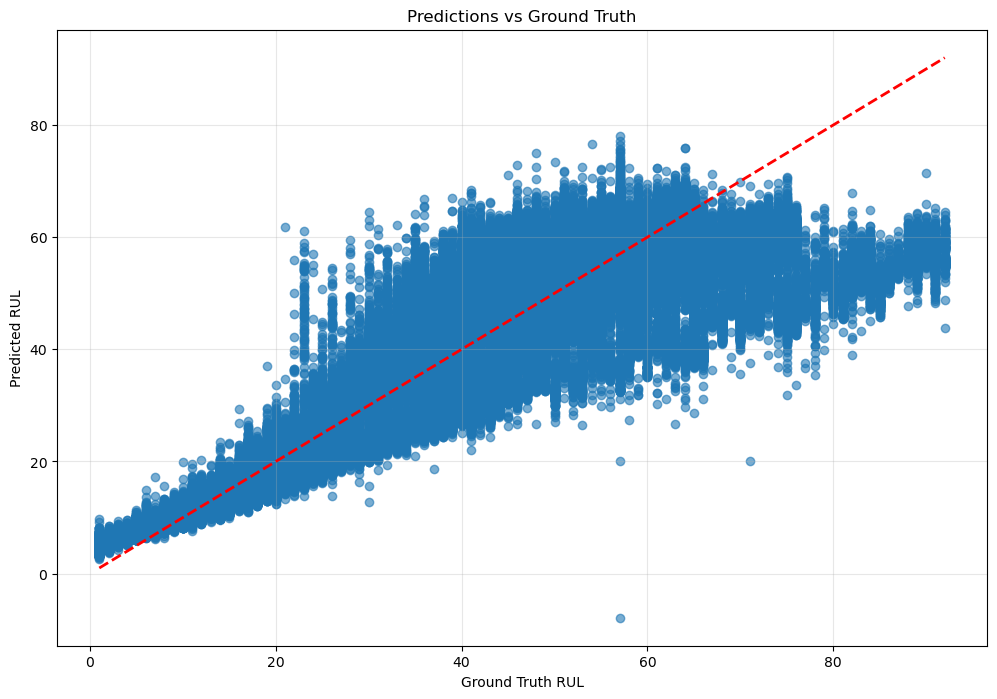

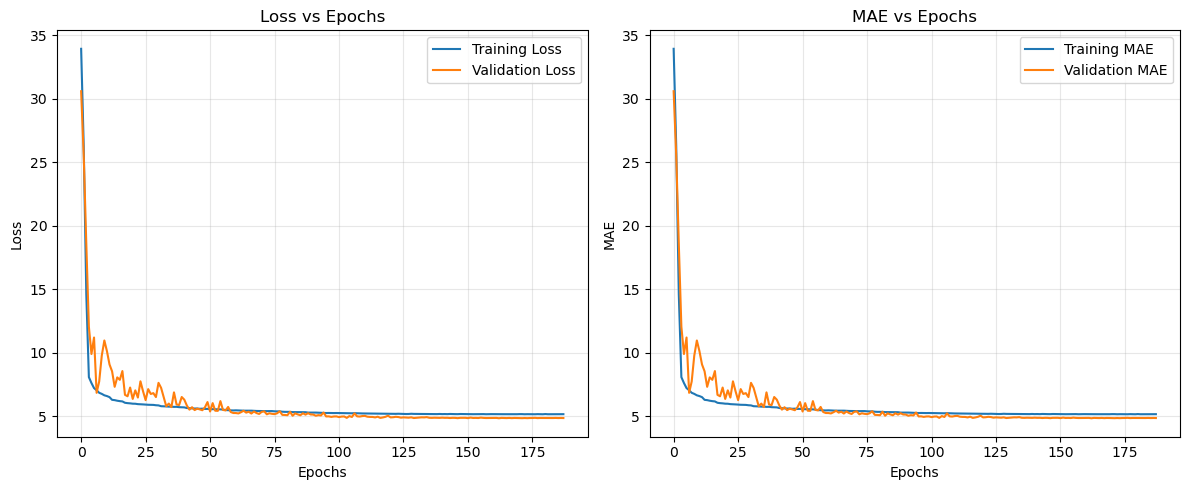

In [51]:
# Predictions and visualization
ypred = model.predict(test_gen)

plt.figure(figsize=(12, 8))
plt.scatter(test_labels.flatten(), ypred.flatten(), alpha=0.6)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--', lw=2)
plt.xlabel('Ground Truth RUL')
plt.ylabel('Predicted RUL')
plt.title('Predictions vs Ground Truth')
plt.grid(True, alpha=0.3)
plt.show()

# Loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()